<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/09.%20Word%20Embedding/09_11_Recommendation_System_using_Document_Embedding_(%EB%AC%B8%EC%84%9C_%EB%B2%A1%ED%84%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%B6%94%EC%B2%9C_%EC%8B%9C%EC%8A%A4%ED%85%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** 09-11 Recommendation System using Document Embedding 

# (문서 벡터를 이용한 추천 시스템)**

* 문서들을 고정된 길이의 벡터로 변환한다면 벡터 간 비교로 문서들을 서로 비교할 수 있습니다. 각 문서를 문서 벡터로 변환하는 방법은 이미 구현된 패키지인 Doc2Vec이나 Sent2Vec 등을 사용하여 학습하는 방법도 존재

-> 단어 벡터를 얻은 뒤
   문서에 존재하는 단어 벡터들의 평균을 
   문서 벡터로 간주할 수 있습니다.


이번에는 문서 내 각 단어들을 Word2Vec을 통해 단어 벡터로 변환하고, 이들의 평균으로 문서 벡터를 얻어 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템을 만들어보겠습니다.

# 1. 데이터 로드

# 현재 코드가 gensim 3.6.0 버전에서 동작합니다.


In [ ]:
import gensim
gensim.__version__

'3.6.0'

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


데이터를 데이터프레임으로 로드하고 전체 문서의 수를 출력해봅시다.



In [ ]:
df[:5]

# 상위 5개.


,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [ ]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

불필요한 열들이 존재하는데, 여기서는 줄거리에 해당하는 열인 'Desc 열'이 중요합니다. 해당 열에 있는 데이터에 대해서 Word2Vec을 학습하기 위해 전처리를 진행합니다. 해당 열에 대해서 전처리를 수행하고 'cleaned'라는 열에 저장해봅시다

In [ ]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [ ]:
df['cleaned'][:5]


0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

전처리 과정에서 빈 값이 생긴 행이 있을 수 있습니다. 빈 값이 생긴 행이 있다면, nan 값으로 변환 후에 해당 행을 제거합니다. 

전체 문서의 수가 1개 줄어들었습니다. 토큰화를 수행하여 corpus라는 리스트에 저장합니다. 해당 리스트 corpus를 통해 Word2Vec을 훈련할 것입니다

In [ ]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


In [ ]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

#  **2. 사전 훈련된 워드 임베딩 사용하기**

Word2Vec을 처음부터 학습할 수도 있겠지만, 데이터가 충분하지 않은 상황에서 사전 훈련된 워드 임베딩을 단어 벡터의 초기값으로 사용하여 성능을 높일 수 있습니다. 여기서는 사전 훈련된 Word2Vec을 로드하고 초기 단어 벡터값으로 사용합니다.

In [ ]:
from google.colab import drive

In [ ]:
# urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                            filename="GoogleNews-vectors-negative300.bin.gz")

word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

# 3. 단어 벡터의 평균 구하기. 



각 문서에 존재하는 단어들의 벡터값의 평균을 구하여 해당 문서의 벡터값을 연산해봅시다.

In [ ]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [ ]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

<ipython-input-27-69ed8f6fd736>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
<ipython-input-27-69ed8f6fd736>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 2381


# **4. 추천 시스템 구현하기**

각 문서 벡터 간의 코사인 유사도를 구합니다.



In [ ]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [ ]:
# 선택한 책에 대해서 코사인 유사도를 이용하여 가장 줄거리가 유사한 5개의 책을 찾아내는 함수를 만듭니다.

def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

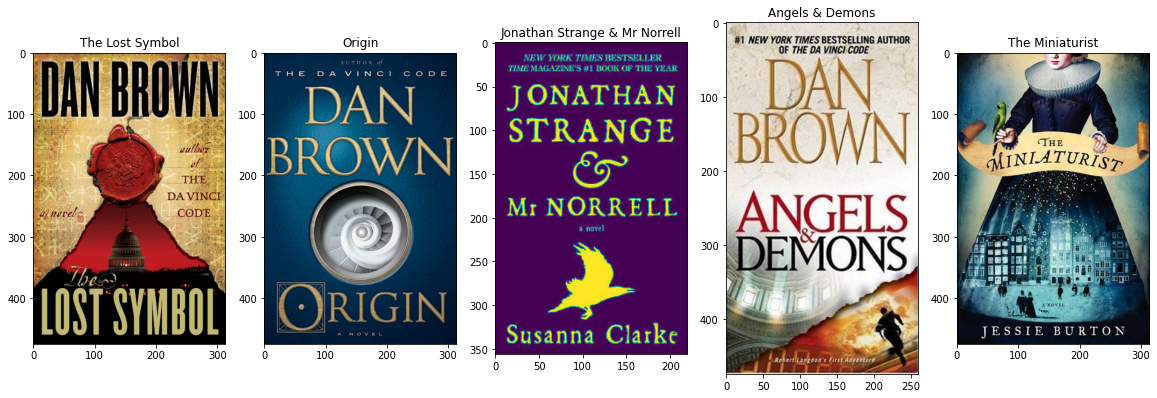

In [ ]:
recommendations("The Da Vinci Code")


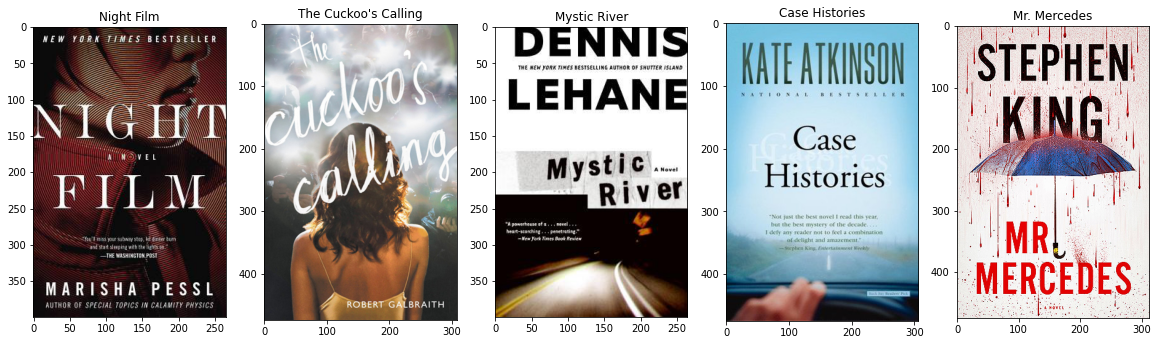

In [ ]:
recommendations("The Murder of Roger Ackroyd")


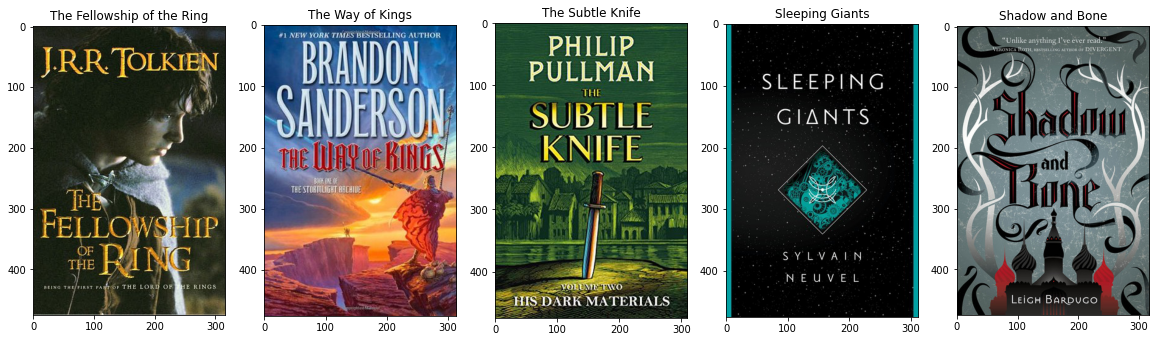

In [ ]:
recommendations("The Lord of the Rings")


In [ ]:
recommendations("Harry Potter")


KeyError: ignored